# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [84]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [85]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv', decimal=',')

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [86]:
# Nombre d'observations dans le dataset
df.shape[0]

9582

In [87]:
# Verification des données manquantes
df.isnull().values.any()

True

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [88]:
# imputation des données manquantes

# Calcul de la medianne et la moyenne
ds_median = df[df.Metier=='Data scientist'].median()[0]
de_mean = df[df.Metier=='Data engineer'].mean()[0]

#filtrer les colomnes d'interet
ds_mask = (df['Metier']=='Data scientist')
de_mask = (df['Metier']=='Data engineer')

#imputation des valeurs manquantes
df.loc[ds_mask, 'Experience'] = df.loc[ds_mask, 'Experience'].fillna(ds_median)
df.loc[de_mask, 'Experience'] = df.loc[de_mask, 'Experience'].fillna(de_mean)


### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [89]:
#Creation du mask pour profile lead data scientist 
lds_mask = (df['Metier']=='Lead data scientist')
#Calcul des moyennes 
mean_exp_ds = df.loc[ds_mask, 'Experience'].mean()
mean_exp_lds = df.loc[lds_mask, 'Experience'].mean()
mean_exp_de = df.loc[de_mask, 'Experience'].mean()

print('Moyenne experience Data scientist= %.2f'%mean_exp_ds)
print('Moyenne experience Lead data scientist= %.2f'%mean_exp_lds)
print('Moyenne experience Data engineer= %.2f'%mean_exp_de)

Moyenne experience Data scientist= 2.24
Moyenne experience Lead data scientist= 3.97
Moyenne experience Data engineer= 2.98


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

Text(0.5,1,"Nombre moyen d'années d'expériences pour chaque métier")

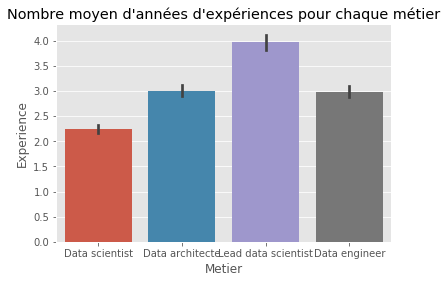

In [90]:
#Representation graphique
sb.barplot(df.Metier, df.Experience)
plt.title('Nombre moyen d\'années d\'expériences pour chaque métier')


### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

In [91]:
# 0-2 ans: debutant
# 2-5 ans: confirmé
# 5-10 ans: Avancé
# >10 ans: Expert

bins = [-1, 2, 5, 10, df['Experience'].max()]
labels=['Débutant', 'Confirmé', 'Avancé' , 'Expert']
df['Experience'] = pd.cut(df.Experience, bins=bins, labels=labels)

#Renommage de la colonne expereince
df = df.rename(columns={'Experience': 'Exp_label'})



### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

Text(0.5,1,'Technos les plus utilisées par nombre de personnes')

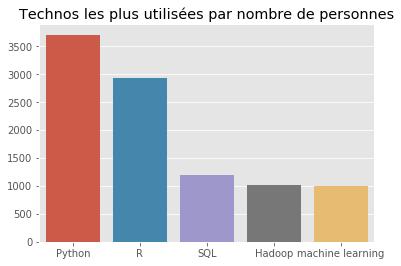

In [92]:
# Calcul des technos les plus utilisées
technos = df['Technologies'].str.cat()
technos = pd.Series(technos.split('/'))
frequent_techno = technos.value_counts()[:5]

#Plot des technos les plus utilisées
sb.barplot(frequent_techno.index, frequent_techno)
plt.title('Technos les plus utilisées par nombre de personnes')



### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

<Container object of 4 artists>

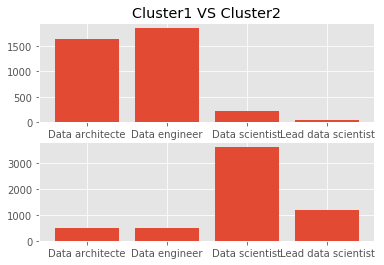

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

my_text = list(df['Technologies'])

#vectorize the text i.e. convert the strings to numeric features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(my_text)

true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=2)
model.fit(X)
df['Cluster'] = model.labels_

# analyse des resultats du clustering
cluster1 = df[df['Cluster']==0]
cluster2 = df[df['Cluster']==1]

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.bar(cluster1.Metier.value_counts().index, cluster1.Metier.value_counts())
ax1.set_title('Cluster1 VS Cluster2')
ax2.bar(cluster2.Metier.value_counts().index, cluster2.Metier.value_counts())


# Interpretation des resultats

- On a réalisé le clustering par rapport aux technologies utilisées par chaque profil
- Comme résultat, on a eu un premier cluster ou la majorité sont des data architect. 
Dans le deuxième cluster la majorité des profils sont des data scientist et des data engineer 


### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

In [94]:
# Prediction des Metiers manquants
from sklearn.ensemble import RandomForestClassifier

# Vectorisation des technos utilisés 
my_text = list(df['Technologies'])
vectorizer = TfidfVectorizer(stop_words='english')
x = vectorizer.fit_transform(my_text)

#filtrage des données ou l'information metier est disponible
indices = np.where(pd.isnull(df['Metier']))
train_mask = np.ones(x.shape[0], dtype=bool)
train_mask[indices] = False
x_train =  x[train_mask]

# Colonne des metier pour train
y_train = df[train_mask]['Metier']


#filtrage des données ou l'information metier est indisponible (Données a predire)
indices = np.where(np.logical_not(pd.isnull(df['Metier'])))
test_mask = np.ones(x.shape[0], dtype=bool)
test_mask[indices] = False
x_test =  x[test_mask]

# Creation du model de prediction
clf = RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

#missing_indices = np.where(pd.isnull(df['Metier']))
#for i,idx in enumerate(missing_indices):
#    df['Metier'][idx] = predictions[i]



### 10) Décrire de façon détaillée les différentes étapes pour mener à bien un projet data complexe.

Dans le cadre d’une campagne de recrutement vous avez reçu un ensemble de cv qui ne sont pas à jour (le poste actuel n’est pas présent). Deux exemple de CV vous sont donnés en pièce jointe (il n'y a pas de mise en page type). Tous les CV sont au format PDF.

On souhaite connaitre le poste actuel de chaque candidat.

-  Quelles sont les différentes étapes nécessaires à la réalisation d'un tel projet?
-  Pour chaque étape, détaillez les taches à accomplir, les méthodes à suivre, les pistes possibles, les points critiques.
-  Justifiez consciencieusement vos choix


* Pour ce problème de prédiction, on pourrait suivre la démarche suivante :

- On crée un fichier csv avec deux colonnes : une colonne nommée "Id_candidat" et une 
  colonne nommée "Technologies" 

- Pour chaque candidats (chaque CV), on extrait ces compétences et on les injectes dans 
  sa ligne appropriée dans la colonne "Technologies"

- On convertie "les Technologies" de chaque candidat qui sont en type texte en type sparse matrix.

- Maitenant qu'on dispose des techno en type sparse matrix, on pourrait réaliser la prédiction.
  En effet, dans la question 9 on a réalisé un modèle de machine learning capable de prédire 
  le métier d'un candidat à partir des ses compétences.

- On applique directement notre modèle crée dans la question 9 aux données d'entrées (techno au type sparse matrix)

- En sortie, on aurait le métier prédit pour chaque candidat, et on pourrait l'ajouter dans une colonne nommée "Métier".

  
 